# Adaptation of Adversarial Tasks Tutorial

## Table of contents
1. [Introduction](#intro1)
2. [Background](#background)
    1. [Omnidirectional Learning](#omni)
    2. [Evaluation Criteria](#eval)
    3. [Adversarial Tasks](#adversarial)
        1. [The Gaussian XOR Task](#xor)
        2. [The Elliptical Rings Task](#rings)
3. [Domain Adaptation Approach to Adversarial Tasks](#intro2)
    1. [Domain Adaptation of Data](#dad)
        1. [Point Cloud Registration](#pcr)
    2. [Domain Adaptation of Posteriors](#dap)


## Introduction <a name="intro1"></a>

Natural biological learning occur gradually over time, in a progressive manner. The organism continues to build on past knowledge using new experiences and data, improving their performance in past and future tasks Various methods, broadly referred to as lifelong learning algorithms, have been introduced to mimic this phenomenon [Rusu, et al. (2016)](https://arxiv.org/abs/1606.04671). Specifically, classical machine learning systems exhibit “catastrophic forgetting” when trained sequentially, meaning their performance on the prior tasks drops precipitously upon training on new tasks [McCloskey, et al. (1989)](https://doi.org/10.1016/S0079-7421(08)60536-8). Lifelong learning algorithms attempt to overcome this phenomenon. 


Previous work in lifelong learning falls loosely into two algorithmic camps: (i) continually updating a fixed parametric model as new tasks arrive, and (ii) adding resources as new tasks arrive [Lee, et al. (2019)](https://doi.org/10.24963/ijcai.2019/393). However, it has been shown that many state of the art lifelong learning algorithms are unable to transfer knowledge forward, and fewer are able to transfer knowledge backward [Vogelstein, et al. (2020)](https://arxiv.org/pdf/2004.12908.pdf). Furthermore, the effects of adversarial tasks in lifelong learning settings have not been thoroughly addressed. It is not uncommon that data between tasks do not follow the same distribution, and task robustness is therefore a desired property in lifelong learning frameworks. 

In this tutorial, we build on the algorithmic framework called "omnidirectional learning". Omnidirectional learning algorithms have demonstrated success in transferring knowledge both forwards and backwards in a variety of scenarios, as described in [Vogelstein, et al. (2020)](https://arxiv.org/pdf/2004.12908.pdf). We investigate the detrimental impacts of learning an adversarial task, and show the effects of domain adaptation methods to alleviate the disruptive effects of divergence between the data probability distribution functions of the tasks.

In [1]:
import numpy as np
import adversarial_adaptation_functions as fn

In [2]:
# Installing pycpd if not avaliable
try:
    import pycpd
except:
    #!pip install pycpd
    import pycpd

**Note:** This notebook tutorial uses functions stored externally within `functions/adversarial_adaptation_functions.py`, to simplify presentation of code. These functions are imported above, along with other libraries.

## Background <a name="background"></a>

### Omnidirectional Learning <a name="omni"></a>
In lifelong learning, instead of one task, there is an environment $T$ of (possibly infinitely) many tasks. We consider lifelong learning in "task-aware" scenarios, where the learner is aware of all task identifiers, meaning the hypotheses are of the form $h:\mathcal{X} \times T \rightarrow \mathcal{Y}$.  In this tutorial, we use the omnidirectional forest (ODIF), a decision forest-based variant for ensembling representations described in [Vogelstein, et al. (2020)](https://arxiv.org/pdf/2004.12908.pdf). 

### Evaluation Criteria <a name="eval"></a>
There exists various proposed criteria for evaluating transfer in the forward and backwards direction in lifelong learning. One such useful measure is the transfer benefit ratio (TBR) introduced by [Pearl, et al. (2019)](https://dl.acm.org/doi/10.1145/3241036), extending directly from relative efficiency from classical statistics. This idea of a TBR is further generalized with forward and backward extensions in [Vogelstein, et al. (2020)](https://arxiv.org/pdf/2004.12908.pdf), of which we present and incorporate below.   

Transfer efficiency is defined as the ratio of the generalization error of (i) an algorithm that has learned only from data associated with a given task, to (ii) the same learning algorithm that also has access to other data. For notation, $R^t$ be the risk associated with task $t$, $R^t(f_n^t )$ denote the risk on task $t$ of the hypothesis learned by $f_n$ only on task $t$ data, and $R^t(f_n)$ denote the risk on task $t$ of the hypothesis learned on all the data. 

The transfer efficiency of algorithm $ f $ for given task $ t $ with sample size $n$ is

$$\mathsf{TE}_n^t(f) := \mathbb{E}\left[{R^t\left(f(\mathbf{S}_n^t)\right)}\right]/\mathbb{E}\left[{R^t\left(f(\mathbf{S}_n))\right)}\right]
$$ 

We say that algorithm $ f $ has transfer learned for task $t$ with data $\mathbf{S}_n$ if and only if $ \mathsf{TE}_n^t(f) > 1 $. We will be using this evaluation metric to assess the impact of adapted adversarial tasks on lifelong learning.

We can specify the direction of transfer with the forward transfer efficiency $\mathsf{FTE}$ and backward transfer efficiency $\mathsf{BTE}$ extensions to transfer efficiency, defined respectively as: 

$$\mathsf{FTE}_n^t(f) := \mathbb{E} [R^t (f(S_n^{t})] / \mathbb{E}[R^t (f(S_n^{<t}))]$$

$$\mathsf{BTE}_n^t(f) := \mathbb{E} [R^t (f(S_n^{<t})] / \mathbb{E}[R^t (f(S_n))]$$


If $\mathsf{FTE}_n^t(f) > 1$, the algorithm demonstrates positive forward transfer, i.e. data from the current task has been used to improve performance on past tasks. Similarly, if $\mathsf{BTE}_n^t(f) > 1$, the algorithm demonstrates positive backward transfer.

### Adversarial Tasks <a name="adversarial"></a>
In the context of lifelong learning, we define a task $t$ to be adversarial with respect to task $t'$ if the true joint distribution of task $t$ without any form of alignment, has no information about task $t$. In other words, training data from task $t'$ can only add noise for task $t$, and this corresponds to $\mathsf{TE}^t(f_n)<1$.

#### The Gaussian XOR Task <a name="xor"></a>
With the above evaluation criteria, lifelong learning through adversarial tasks in a simple environment can therefore be demonstrated with the Gaussian XOR distribution and various "adversarial" transformations to the Gaussian XOR distribution.

Gaussian XOR is a two-class classification problem, where:
- Class 0 is drawn from two Gaussians with $\mu = \pm [0.5, 0.5]^T$ and $\sigma^2 = I$.
- Class 1 is drawn from two Gaussians with $\mu = \pm [0.5, -0.5]^T$ and $\sigma^2 = I$.

By applying transformations to the Gaussian XOR distribution, we can create various distrbutions that share similar discriminant boundaries as Gaussian XOR, allowing for transfer learning, yet produce a fundamentally different distribution with mismatchs that impede the transfer of learning. 

The transformations that we will use in this experiment can be broadly classified as rigid, affine, and nonlinear. Below, we will visualize the Gaussian XOR distribution and various Gaussian XOR derived distributions for each category of transformation.

<u> Rigid Transformation </u> (Rotation)

Rigid transformations strictly preserve the Euclidean distance between each pair of points. One transformation belonging to this category is a rotation. We rotated the Gaussian XOR distribution to produce the Gaussian RXOR (Rotated-XOR) distribution. 

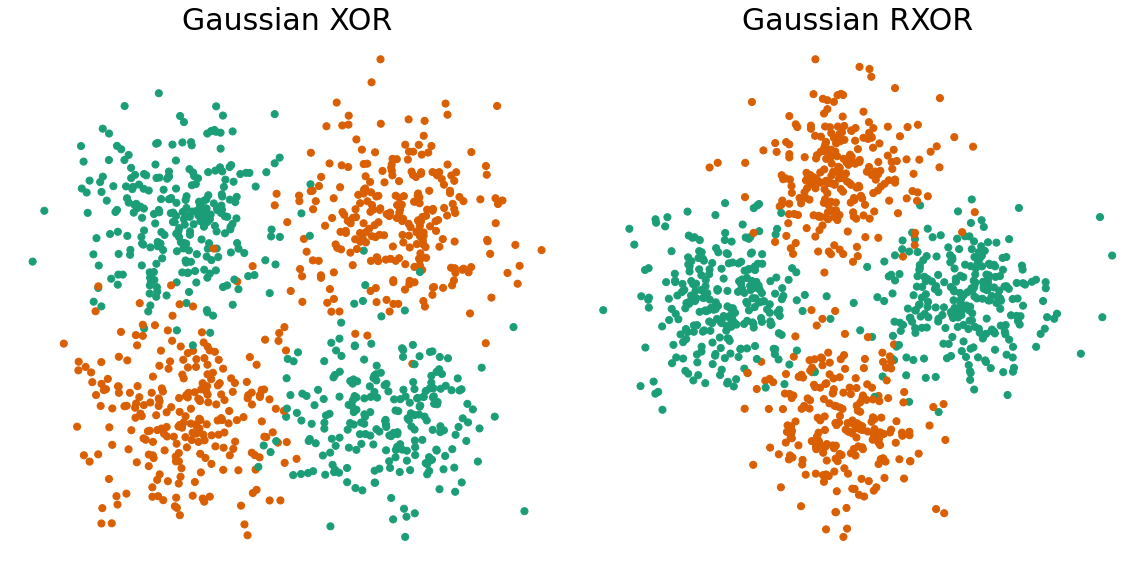

In [3]:
fn.view_rxor()

<u> Affine Transformation </u> (Shear)

Affine transformations are transformations that preserve collinearity and ratios of distances. One transformation belonging to this category is a shear. We sheared the Gaussian XOR distribution to produce the Gaussian SXOR (Sheared-XOR) distribution. 

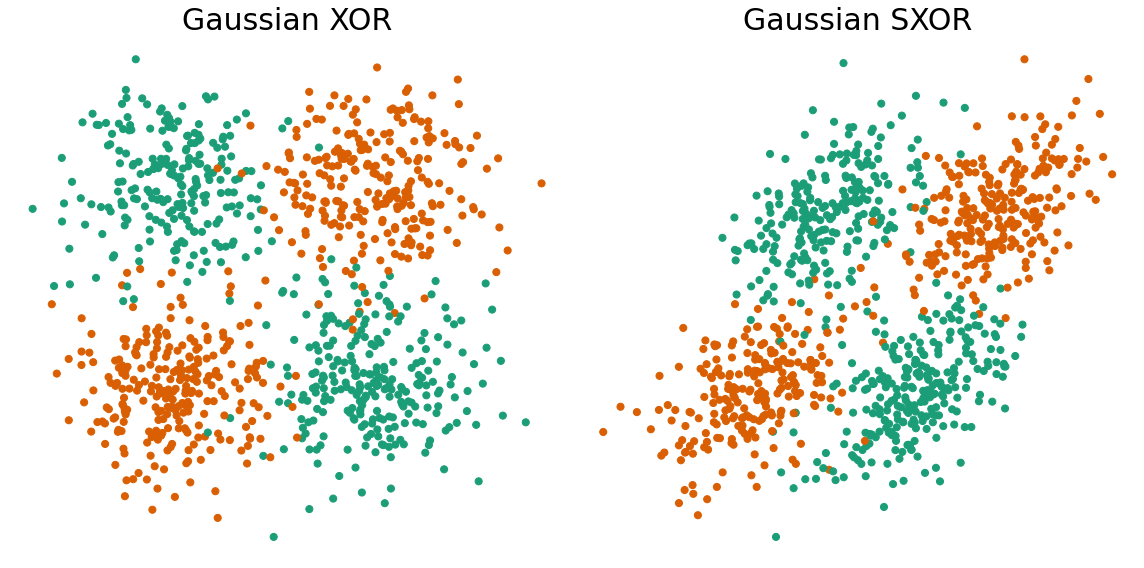

In [4]:
fn.view_sxor()

<u> Nonlinear Transformation </u> (Double Shear and Divergent Translation)

Nonlinear transformations generally refer to transformations that change the linear relationships between variables. Piece-wise transformations often fall into this category. To simulate nonlinear transformations of the data, we introduce the Gaussian SSXOR (double-Shear XOR) and the Gaussian TXOR (divergent-Translated XOR). The Gaussian SSXOR distribution was generated by shearing the top half and bottom half of the Gaussian XOR distribution in different directions. The Gaussian TXOR distribution was generated by translating the top half and bottom half of the Gaussian XOR distribution in different directions

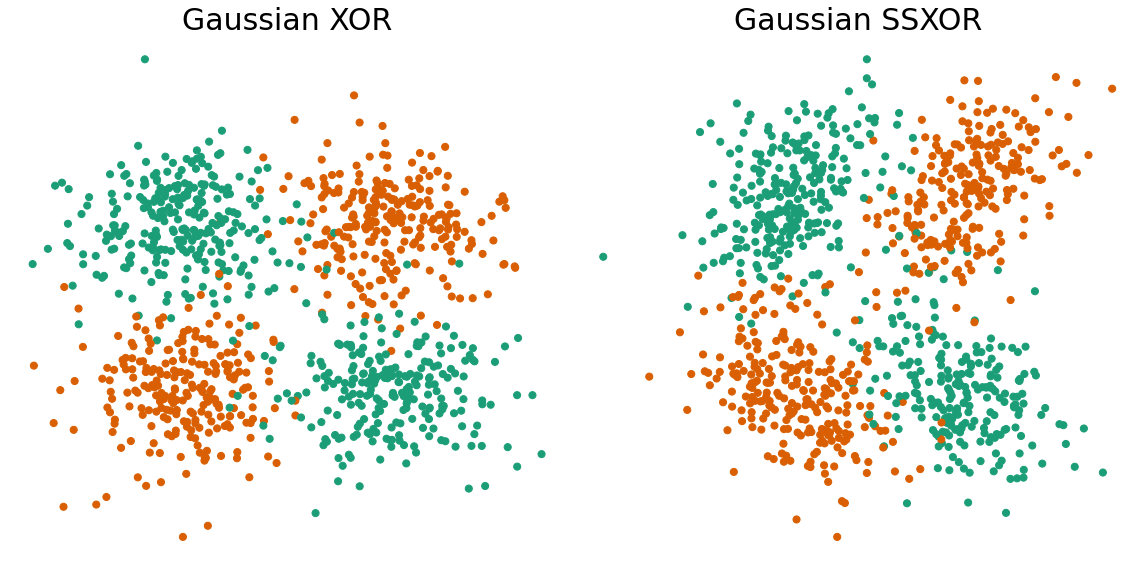

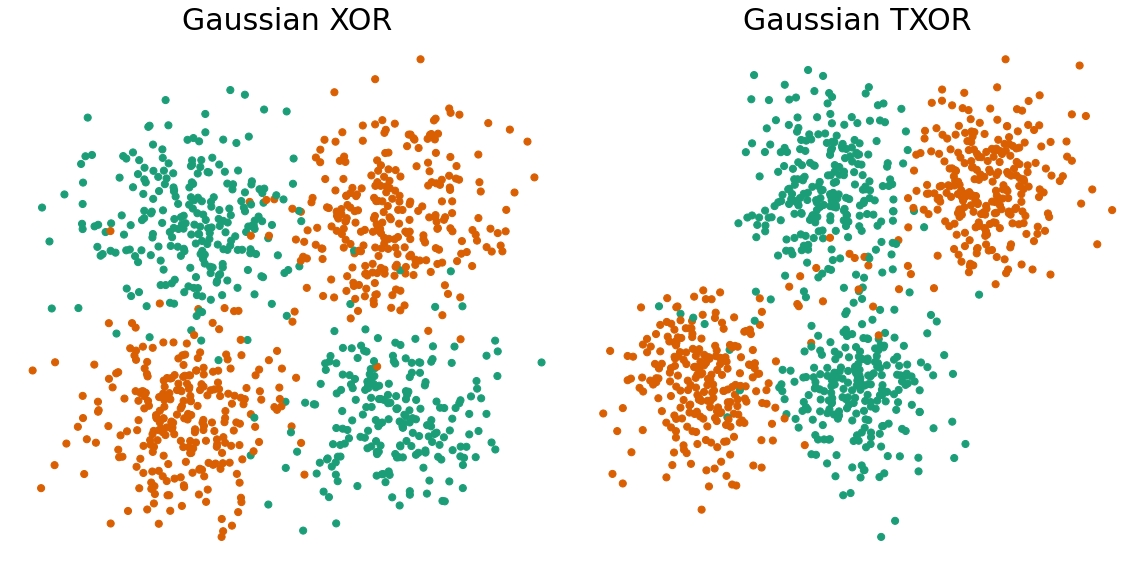

In [5]:
fn.view_ssxor()
fn.view_txor()

#### The Elliptical Rings Task <a name="rings"></a>
To demonstate lifelong learning through adversarial tasks in a slightly more complex enviornment, we turn to the elliptical rings task.

Consider two adjacent elliptical rings defined by three major radii, $R_i< R_m< R_o$, and three minor radii, $r_i< r_m< r_o$, such that the areas of the two rings are the same, specifically, $R_or_o\pi-R_mr_m\pi = R_mr_m\pi-R_ir_i\pi$. It can be regarded as a two-class classification problem where class 1 and class 2 are drawn uniformly from the two rings, respectively. 

Below we visualize the original elliptical distribution as well as the rotation, shear, and double shear transformations of the elliptical.

<u> Rigid Transformation </u> (Rotation)

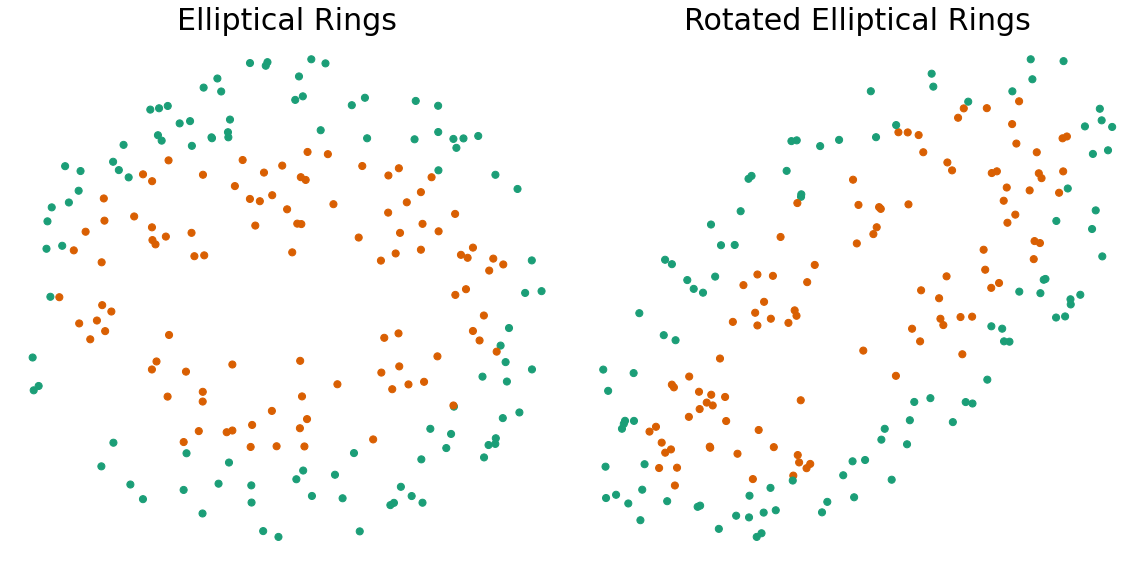

In [6]:
fn.view_rEllip()

<u> Affine Transformation </u> (Shear)

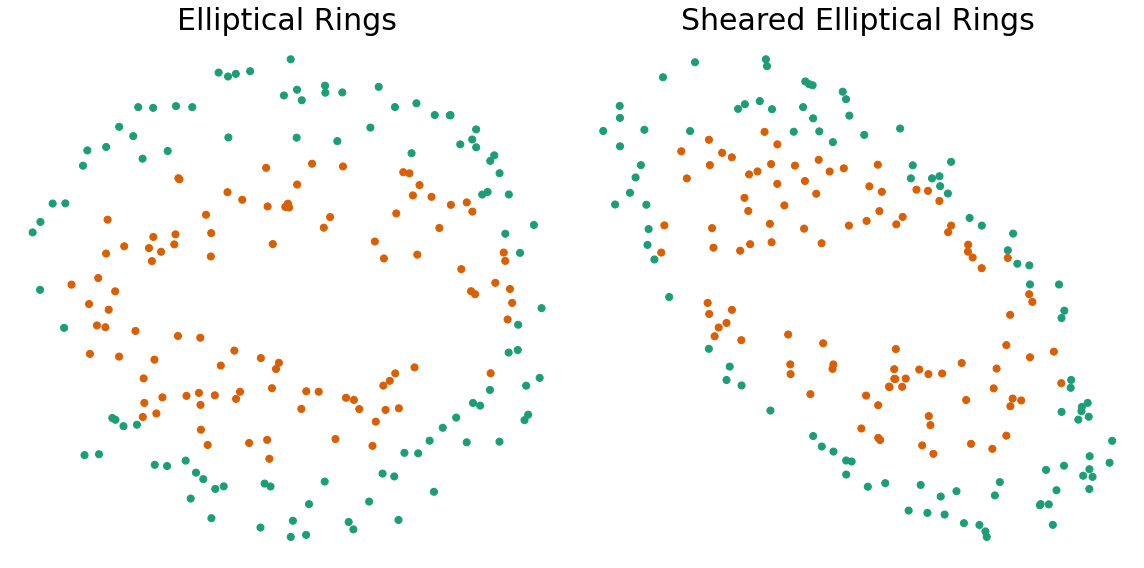

In [7]:
fn.view_sEllip()

<u> Nonlinear Transformation </u> (Double Shear)

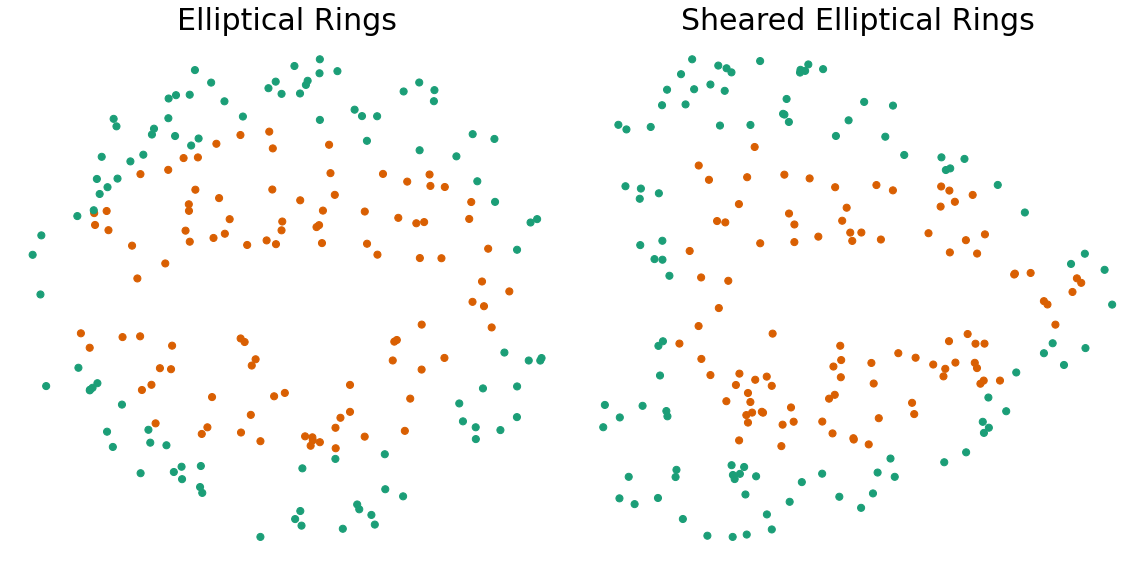

In [8]:
fn.view_ssEllip()

## Domain Adapation Approach to Adversarial Tasks<a name="intro2"></a>

To alleviate the detrimental impacts of learning an adversarial task, we can try to "adapt" the adversarial task or model. In the space below, we will be exploring two approaches: domain adaptation of data and domain adaptation of posteriors.

### Domain Adaptation of Data <a name="dad"></a>
Adversarial tasks in lifelong learning can be addressed through a domain adaptation of adversaial data perspective. Formally, in domain adaptation problems, one assumes the existence of two distinct joint probability distributions $P_s(\textbf{x}^s, y)$ and $P_t(\textbf{x}^t, y)$, respectively related to a source and a target domains, noted as $\Omega_s$ and $\Omega_t$. The source and target empirical distributions correspond to two unaligned tasks, and this domain drift can be seen as an unknown nonlinear transformation of the input space. We also assume that this transformation preserves the conditional distribution, i.e.

$$P_s(y|\textbf{x}^s) = P_t(y|T(\textbf{x}^s))$$

This means that the label information is preserved by the transformation, and with "task-aware" lifelong learning, we can take advantage of class labels to regularize and better recover the transformation during training.

#### Point Cloud Registration <a name="pcr"></a>
We can formulate the exercise of adapting the domain of one task to another as a point set registration problem. The goal of point set registration is to recover a spatial transformation that assigns correspondence between two sets of points, called point sets. In our formulation, we treat the data associated with each task as a point set.

For efficient information transfer, we want to preserve the topology of the adversarial distribution. As such, we are interested in two main categories of registration algorithms: rigid transformations and affine transformations. 

### RXOR Experiment

In [9]:
#main hyperparameters
angle_sweep = range(0,91,10)
task1_sample = 100
task2_sample = 100
mc_rep = 20

In [10]:
mean_te1 = fn.bte_v_angle(angle_sweep, task1_sample, task2_sample, mc_rep)
mean_te2 = fn.bte_v_angle(angle_sweep, task1_sample, task2_sample, mc_rep, register_cpd=True)
mean_te3 = fn.bte_v_angle(angle_sweep, task1_sample, task2_sample, mc_rep, register_icp=True)
mean_te4 = fn.bte_v_angle(angle_sweep, task1_sample, task2_sample, mc_rep, register_nlr=True)

In [11]:
mean_te5 = fn.fte_v_angle(angle_sweep, task1_sample, task2_sample, mc_rep)
mean_te6 = fn.fte_v_angle(angle_sweep, task1_sample, task2_sample, mc_rep, register_cpd=True)
mean_te7 = fn.fte_v_angle(angle_sweep, task1_sample, task2_sample, mc_rep, register_icp=True)
mean_te8 = fn.fte_v_angle(angle_sweep, task1_sample, task2_sample, mc_rep, register_nlr=True)

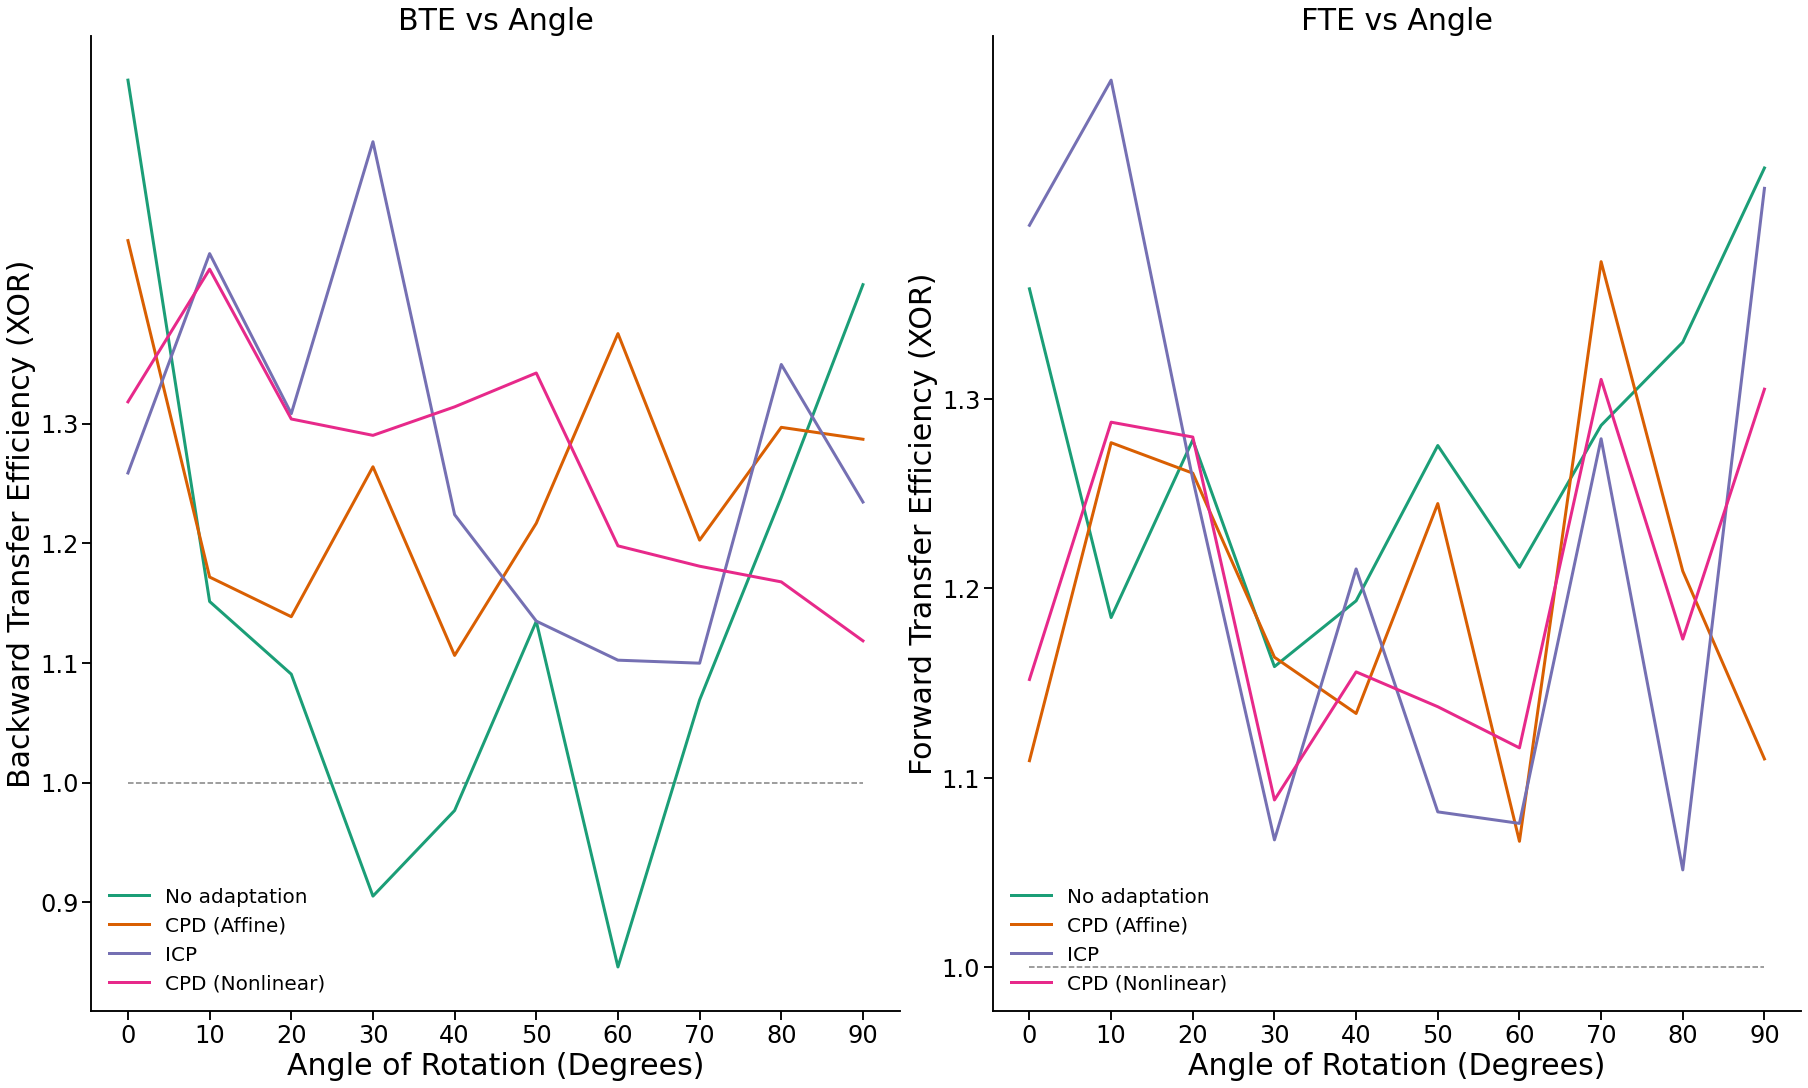

In [12]:
btes = [mean_te1, mean_te2, mean_te3, mean_te4]
ftes = [mean_te5, mean_te6, mean_te7, mean_te8]
fn.plot_te_v_angle(angle_sweep, btes, ftes)

### SXOR Experiment

In [13]:
#main hyperparameters
shear_sweep = [x * 10**e for e in range(-2, 3) for x in [1, 2, 5]];
task1_sample = 100
task2_sample = 100
mc_rep = 20

In [14]:
mean_te1 = fn.bte_v_shear(shear_sweep, task1_sample, task2_sample, mc_rep)
mean_te2 = fn.bte_v_shear(shear_sweep, task1_sample, task2_sample, mc_rep, register_cpd=True)
mean_te3 = fn.bte_v_shear(shear_sweep, task1_sample, task2_sample, mc_rep, register_icp=True)
mean_te4 = fn.bte_v_shear(shear_sweep, task1_sample, task2_sample, mc_rep, register_nlr=True)

In [15]:
mean_te5 = fn.fte_v_shear(shear_sweep, task1_sample, task2_sample, mc_rep)
mean_te6 = fn.fte_v_shear(shear_sweep, task1_sample, task2_sample, mc_rep, register_cpd=True)
mean_te7 = fn.fte_v_shear(shear_sweep, task1_sample, task2_sample, mc_rep, register_icp=True)
mean_te8 = fn.fte_v_shear(shear_sweep, task1_sample, task2_sample, mc_rep, register_nlr=True)

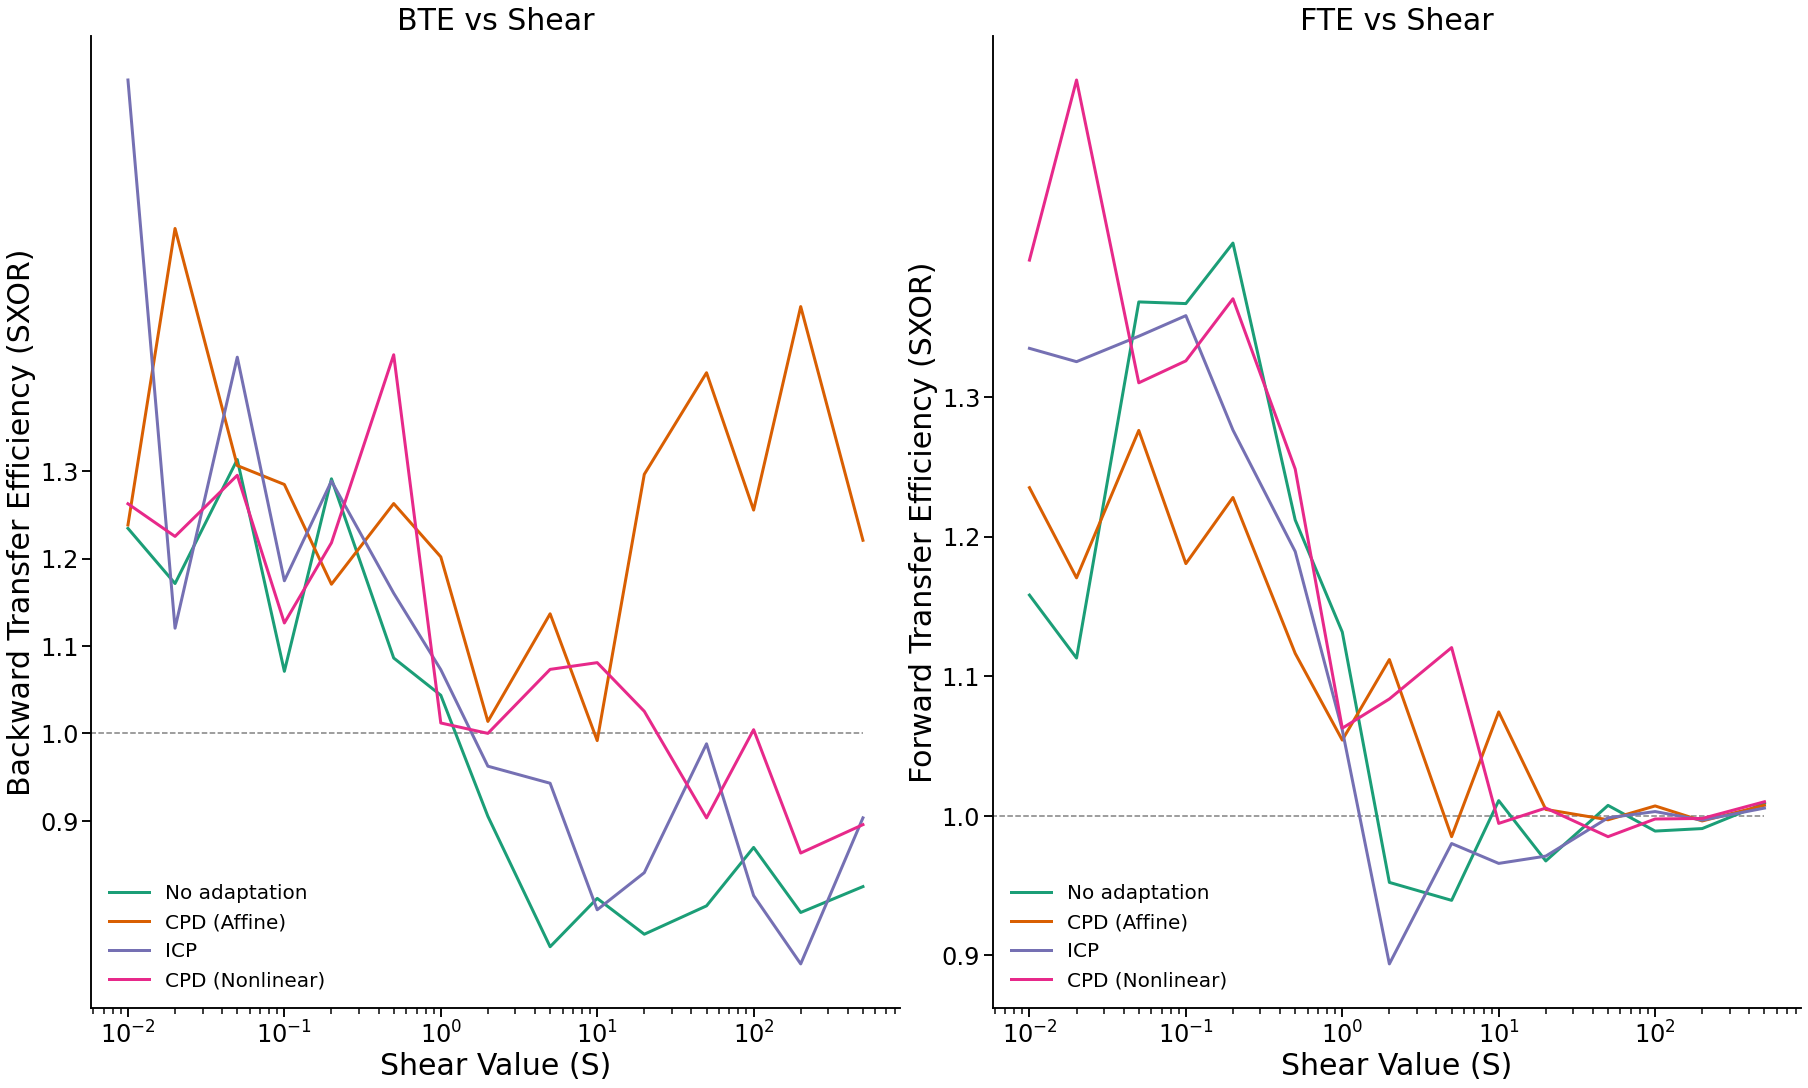

In [16]:
btes = [mean_te1, mean_te2, mean_te3, mean_te4]
ftes = [mean_te5, mean_te6, mean_te7, mean_te8]
fn.plot_te_v_shear(shear_sweep, btes, ftes)

### SSXOR Experiment

In [17]:
#main hyperparameters
shear_sweep = [x * 10**e for e in range(-2, 3) for x in [1, 2, 5]];
task1_sample = 100
task2_sample = 100
mc_rep = 20

In [18]:
mean_te1 = fn.bte_v_double_shear(shear_sweep, task1_sample, task2_sample, mc_rep)
mean_te2 = fn.bte_v_double_shear(shear_sweep, task1_sample, task2_sample, mc_rep, register_cpd=True)
mean_te3 = fn.bte_v_double_shear(shear_sweep, task1_sample, task2_sample, mc_rep, register_icp=True)
mean_te4 = fn.bte_v_double_shear(shear_sweep, task1_sample, task2_sample, mc_rep, register_nlr=True)

In [19]:
mean_te5 = fn.fte_v_double_shear(shear_sweep, task1_sample, task2_sample, mc_rep)
mean_te6 = fn.fte_v_double_shear(shear_sweep, task1_sample, task2_sample, mc_rep, register_cpd=True)
mean_te7 = fn.fte_v_double_shear(shear_sweep, task1_sample, task2_sample, mc_rep, register_icp=True)
mean_te8 = fn.fte_v_double_shear(shear_sweep, task1_sample, task2_sample, mc_rep, register_nlr=True)

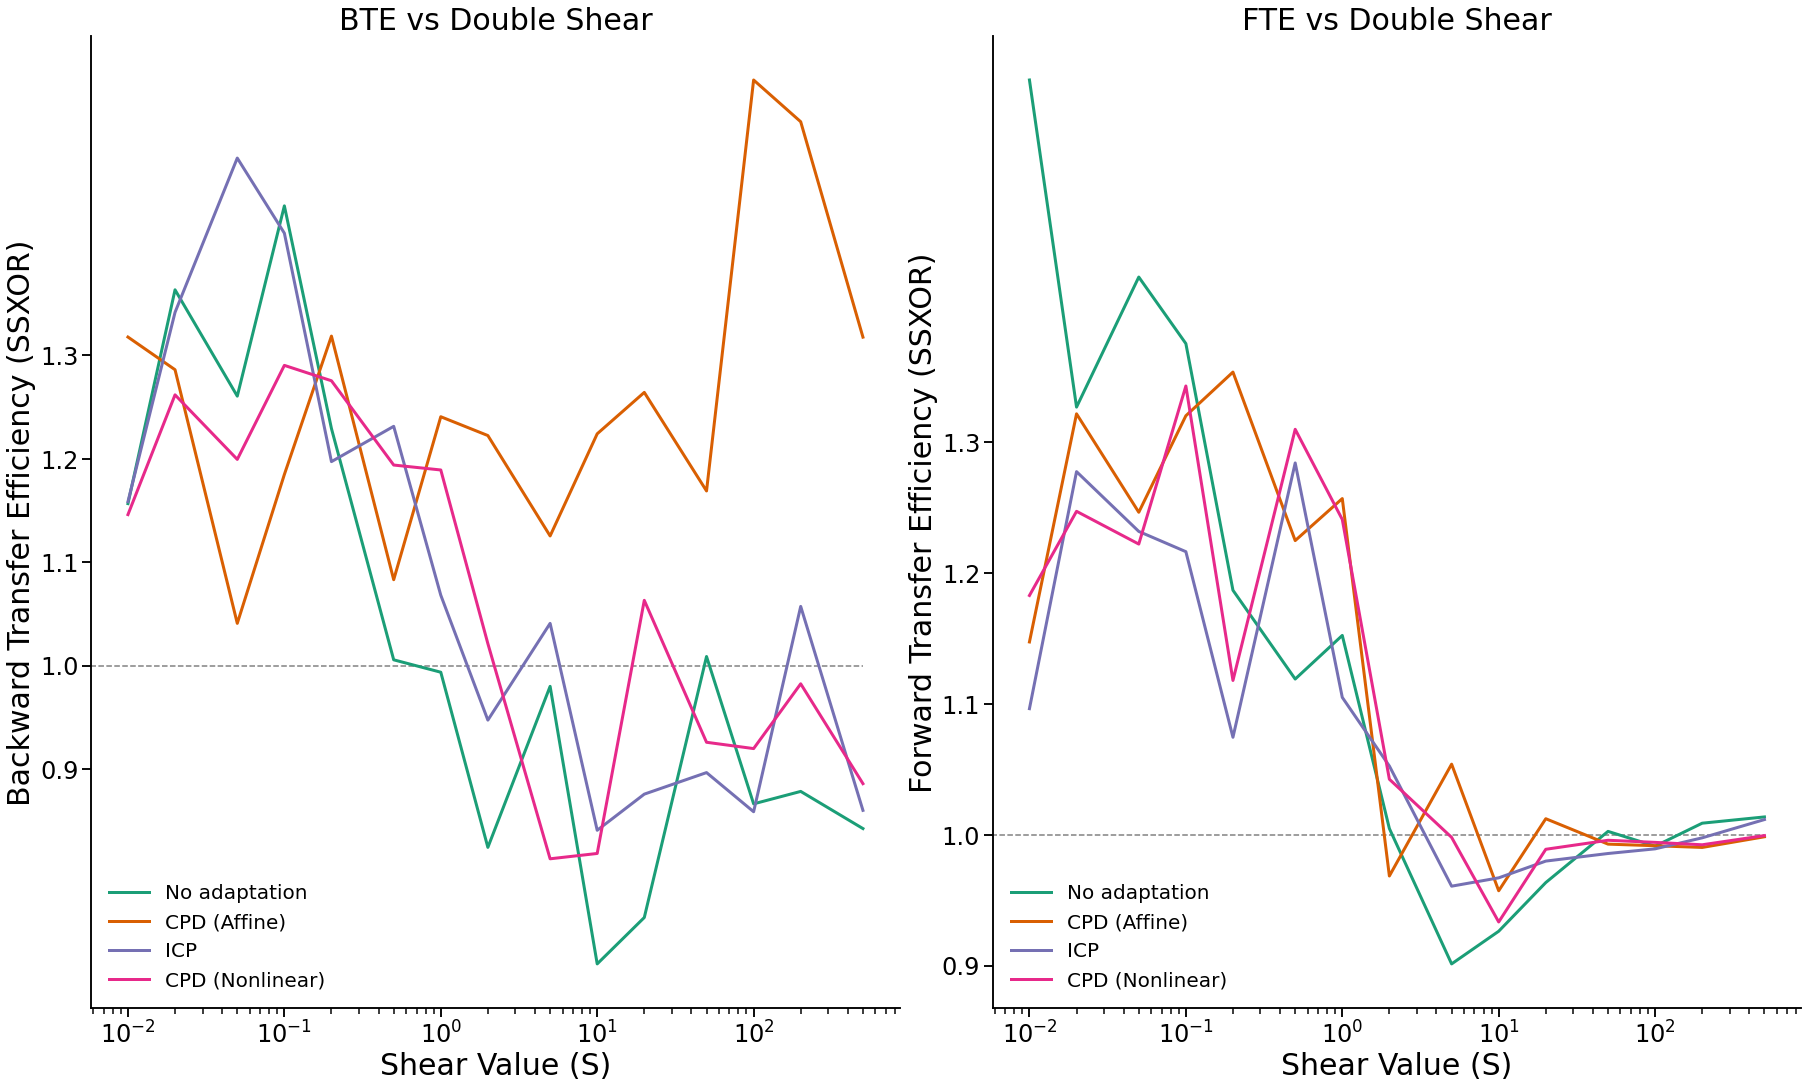

In [20]:
btes = [mean_te1, mean_te2, mean_te3, mean_te4]
ftes = [mean_te5, mean_te6, mean_te7, mean_te8]
fn.plot_te_v_double_shear(shear_sweep,  btes, ftes)

### TXOR Experiment

In [3]:
#main hyperparameters
trans_sweep = np.arange(0, 2.25, 0.25);
task1_sample = 100
task2_sample = 100
mc_rep = 20

In [4]:
mean_te1 = fn.bte_v_translate(trans_sweep, task1_sample, task2_sample, mc_rep)
mean_te2 = fn.bte_v_translate(trans_sweep, task1_sample, task2_sample, mc_rep, register_cpd=True)
mean_te3 = fn.bte_v_translate(trans_sweep, task1_sample, task2_sample, mc_rep, register_icp=True)
mean_te4 = fn.bte_v_translate(trans_sweep, task1_sample, task2_sample, mc_rep, register_nlr=True)

In [5]:
mean_te5 = fn.fte_v_translate(trans_sweep, task1_sample, task2_sample, mc_rep)
mean_te6 = fn.fte_v_translate(trans_sweep, task1_sample, task2_sample, mc_rep, register_cpd=True)
mean_te7 = fn.fte_v_translate(trans_sweep, task1_sample, task2_sample, mc_rep, register_icp=True)
mean_te8 = fn.fte_v_translate(trans_sweep, task1_sample, task2_sample, mc_rep, register_nlr=True)

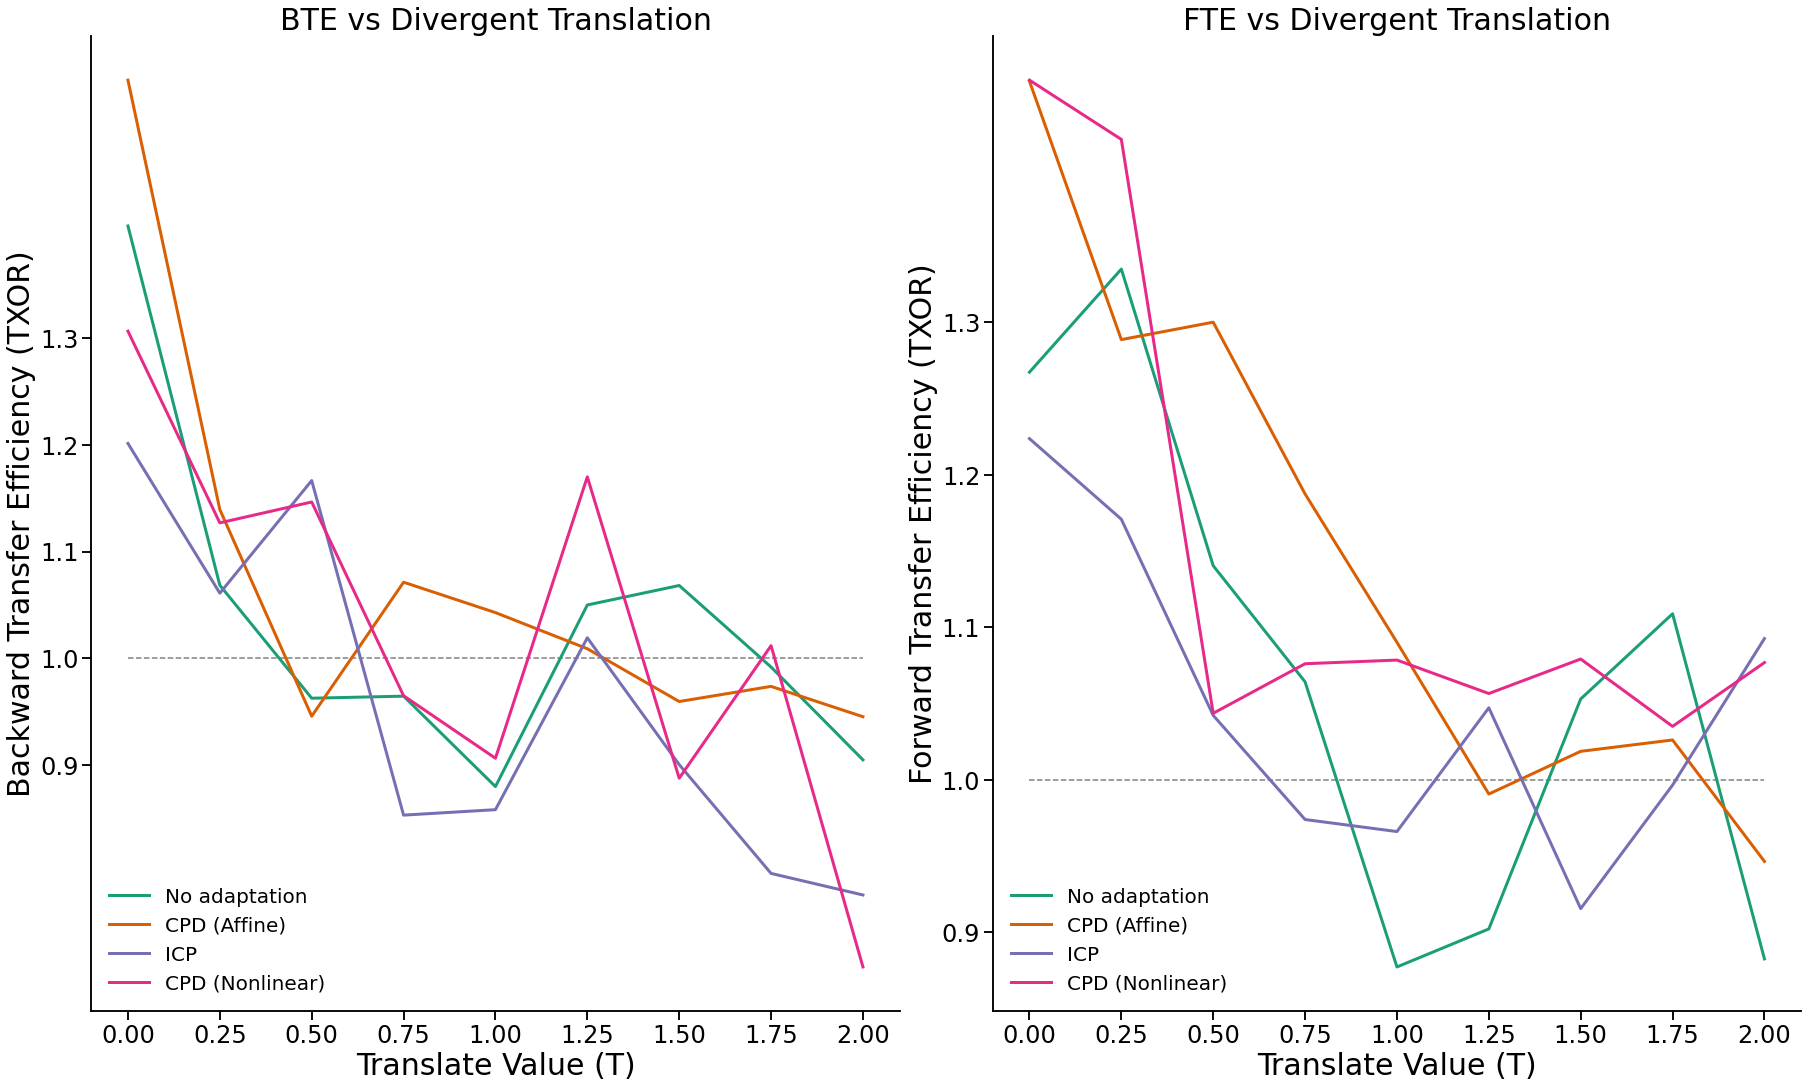

In [6]:
btes = [mean_te1, mean_te2, mean_te3, mean_te4]
ftes = [mean_te5, mean_te6, mean_te7, mean_te8]
fn.plot_bte_v_translate(trans_sweep,  btes, ftes)

### Domain Adaptation of Posteriors <a name="dap"></a>